In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

In [2]:
try:
    print("Loading customer metrics...")
    customer_features = pd.read_csv('customer_metrics.csv')
    print("Data loaded successfully!")

    customer_features = customer_features.drop(columns=['CustomerID'])
except Exception as e:
    print(f"An error occurred while loading data: {e}")

Loading customer metrics...
Data loaded successfully!


In [3]:
try:
    print("Normalizing features...")
    
    numeric_features = customer_features.select_dtypes(include=[np.number])  
    
    # Normalize the numeric features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(numeric_features)  
    
    print("Features normalized successfully!")
except Exception as e:
    print(f"An error occurred while normalizing features: {e}")


Normalizing features...
Features normalized successfully!


In [4]:
try:
    print("Finding optimal clusters...")
    db_scores = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(normalized_features)
        db_scores.append(davies_bouldin_score(normalized_features, clusters))
        silhouette_scores.append(silhouette_score(normalized_features, clusters))

    print("Optimal clusters found!")
except Exception as e:
    print(f"An error occurred while finding clusters: {e}")


Finding optimal clusters...


Optimal clusters found!


Plotting evaluation metrics...


Evaluation plot saved as 'clustering_evaluation.png'.


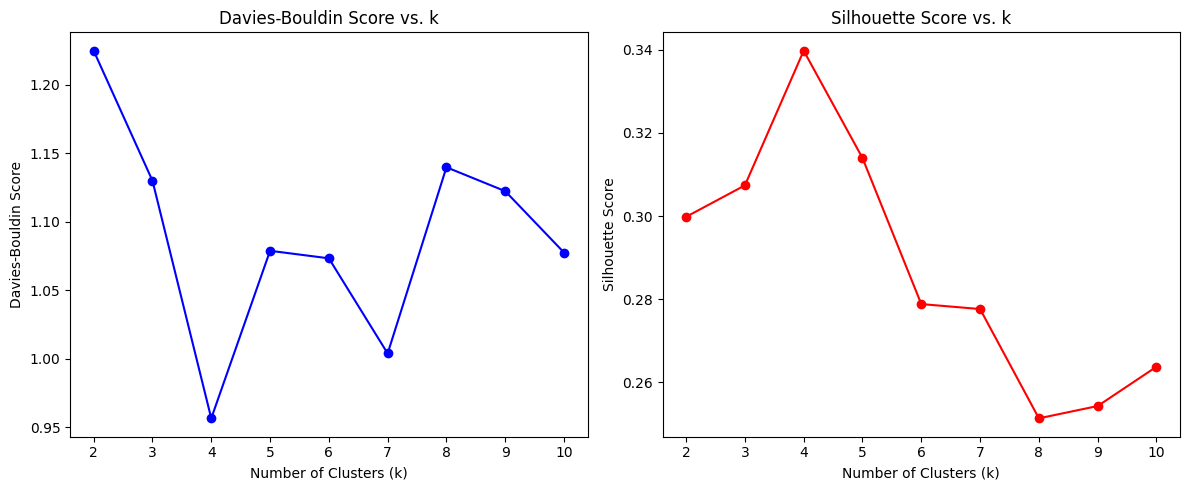

In [5]:
try:
    print("Plotting evaluation metrics...")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, db_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score vs. k')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k')
    plt.tight_layout()
    plt.savefig('clustering_evaluation.png')  # Save plot
    print("Evaluation plot saved as 'clustering_evaluation.png'.")
except Exception as e:
    print(f"An error occurred while plotting evaluation metrics: {e}")


In [6]:
try:
    optimal_k = k_range[np.argmin(db_scores)]
    print(f"Optimal number of clusters: {optimal_k}")
except Exception as e:
    print(f"An error occurred while determining optimal clusters: {e}")


Optimal number of clusters: 4


In [7]:
try:
    if 'optimal_k' in locals():  # Check if optimal_k is defined
        print("Fitting final KMeans model...")
        final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = final_kmeans.fit_predict(normalized_features)
        customer_features['Cluster'] = clusters
        print("KMeans model fitted successfully!")
    else:
        print("Optimal number of clusters is not defined.")
except Exception as e:
    print(f"An error occurred while fitting final KMeans model: {e}")


Fitting final KMeans model...
KMeans model fitted successfully!


Visualizing clusters...


Cluster visualization saved as 'cluster_visualization.png'.


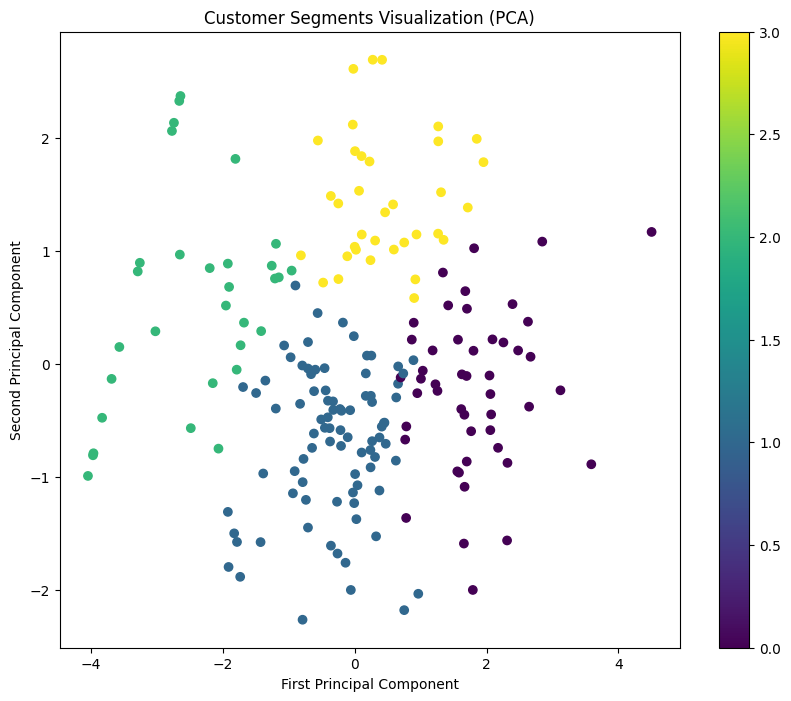

In [8]:
try:
    print("Visualizing clusters...")
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(normalized_features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
    plt.title('Customer Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.savefig('cluster_visualization.png')
    print("Cluster visualization saved as 'cluster_visualization.png'.")
except Exception as e:
    print(f"An error occurred while visualizing clusters: {e}")


In [9]:
try:
    print("Summarizing clusters...")

    if 'Cluster' in customer_features.columns:  # Check if 'Cluster' column is present
        cluster_summary = customer_features.groupby('Cluster').agg({
            'Transaction_Count': 'mean',
            'Total_Spent': 'mean',
            'Customer_Lifetime_Days': 'mean',
            'Avg_Transaction_Value': 'mean'
        }).round(2)

        # Create the PDF report
        pdf_filename = 'Pratap_Pawar_Clustering.pdf'
        c = canvas.Canvas(pdf_filename, pagesize=letter)
        width, height = letter

        # Title
        c.setFont("Helvetica-Bold", 16)
        c.drawString(72, height - 40, "Customer Segmentation Results")

        # Add the clustering details
        c.setFont("Helvetica", 12)
        c.drawString(72, height - 80, f"Number of Clusters: {optimal_k}")  # Using f-string for dynamic value
        c.drawString(72, height - 100, f"Davies-Bouldin Index: {min(db_scores):.3f}")
        c.drawString(72, height - 120, f"Silhouette Score: {silhouette_scores[np.argmin(db_scores)]:.3f}")

        # Add the cluster summary table
        c.drawString(72, height - 160, "Cluster Characteristics:")
        y_position = height - 180
        for index, row in cluster_summary.iterrows():
            c.drawString(72, y_position, f"Cluster {index}:")
            y_position -= 20
            for col, value in row.items():
                c.drawString(92, y_position, f"{col}: {value}")
                y_position -= 20
            y_position -= 10  # Extra space between clusters

        # Add key findings and recommendations
        c.drawString(72, y_position, "Key Findings:")
        y_position -= 20
        # Corrected f-strings here for dynamic content
        c.drawString(92, y_position, f"1. Optimal number of clusters: {optimal_k} (based on Davies-Bouldin Index)")
        y_position -= 20
        c.drawString(92, y_position, "2. The clusters show distinct patterns in terms of:")
        y_position -= 20
        c.drawString(92, y_position, "- Purchase frequency")
        y_position -= 20
        c.drawString(92, y_position, "- Total spending")
        y_position -= 20
        c.drawString(92, y_position, "- Customer lifetime")
        y_position -= 20
        c.drawString(92, y_position, "- Average transaction value")
        y_position -= 20

        c.drawString(72, y_position, "Recommendations:")
        y_position -= 20
        c.drawString(92, y_position, "1. Develop targeted marketing strategies for each segment")
        y_position -= 20
        c.drawString(92, y_position, "2. Customize product recommendations based on cluster characteristics")
        y_position -= 20
        c.drawString(92, y_position, "3. Adjust customer service approaches for different segments")

        # Save the PDF
        c.save()

        print(f"Clustering analysis completed successfully! PDF saved as {pdf_filename}")
    else:
        print("Cluster column not found.")
except Exception as e:
    print(f"An error occurred while summarizing clusters: {e}")


Summarizing clusters...
Clustering analysis completed successfully! PDF saved as Pratap_Pawar_Clustering.pdf
